In [1]:


import os
import json
import datetime
import pathlib
import time
import imp
import cv2
import carla
from collections import deque

import torch
import carla
import numpy as np
from PIL import Image
from easydict import EasyDict

import torchvision.transforms as T
# from leaderboard.autoagents import autonomous_agent
import math
import yaml

from optical_flow import optical_flow
from segmentation import segmentation
from rgb_seg import UNet, Unetpad, group_segment

# from team_code_transfuser.alg1_pycuda import Algorithm1
from alg1_pycuda_copy import Algorithm1 #
from alg2 import Algorithm2
from srunner.scenariomanager.carla_data_provider import CarlaDataProvider
# from submission_agent import HybridAgent
from optical_flow import OpticalFlowVisualizer
from collections import deque
import torchvision.transforms as transforms

from memory_profiler import profile

try:
    import pygame
except ImportError:
    raise RuntimeError("cannot import pygame, make sure pygame package is installed")

def get_entry_point():
    return "agent"

import matplotlib.pyplot as plt

/home/haoming/anaconda3/envs/tfuse-pharuj/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  


pygame 2.0.1 (SDL 2.0.14, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class TF():
    def __init__(self):
        self.fov = 120
        self.camera_width = 960
        self.camera_height = 480
        self.ppd = self.camera_width / self.fov
        # define ourselves # original size
        self.camera_size_x = 0.096
        self.camera_size_y = 0.048
        
        # NOTE: for control mapping
        self.delta_time = 0.05 # CarlaDataProvider.get_world().get_settings().fixed_delta_seconds
        self.throttle_controller = PIDController(K_P=5.0, K_I=0.5, K_D=1, n=20) # throttle PID controller
        self.c_speed_sqrt = 0.032 # constant for throttle_control
        self.c_acc = 0.025
        self.c_w_sq = 0.04
        self.c_w = 0.01
        self._step = -1
        self.turning_radius = 2.5 # This is the minimum turning radius of the vehicle when steer = 1
        self.agent_front2back_whl = 2.9 # This property are from agent_vehicle.get_physics_control()
        self.agent_backwhl2cm = 1.75 # This property are from agent_vehicle.get_physics_control()
        
        self._set_certificate_bound(x_deg_close=42, x_deg_far=32, y_deg=10, decay_temp=1.1, offset_scale=0.002)
        self.alg1_solver = Algorithm1(self.focal_len, (self.camera_width, self.camera_height), self.X, self.Y, self.certification_offset) 
        self.optical_flow = optical_flow(self.camera_height, self.camera_width, self.meters_per_pixel_x, self.meters_per_pixel_y)
        
    def _create_XY(self, camera_x_idx_to_x, camera_y_idx_to_y):

        x_mid = self.camera_width // 2
        y_mid = self.camera_height // 2
        xaxis = np.linspace(-x_mid, x_mid, self.camera_width)
        yaxis = np.linspace(-y_mid, y_mid, self.camera_height)

        X, Y = np.meshgrid(xaxis, yaxis)
        X = X * camera_x_idx_to_x
        Y = Y * camera_y_idx_to_y
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)

        return X, Y

    def _set_certificate_bound(self, x_deg_close=42, x_deg_far=32, y_deg=10, decay_temp=1.1, offset_scale=0.002):
        # relate to SC boundary
        self.meters_per_pixel_x = self.camera_size_x / self.camera_width
        self.meters_per_pixel_y = self.camera_size_y / self.camera_height
        
        self.optical_flow = optical_flow(self.camera_height, self.camera_width, self.meters_per_pixel_x, self.meters_per_pixel_y)
        
        # https://github.com/carla-simulator/carla/issues/56
        # assume fov is measured horizontally
        self.focal_len = self.camera_size_x / 2 / np.tan(np.deg2rad(self.fov / 2))
        X, Y = self._create_XY(self.meters_per_pixel_x, self.meters_per_pixel_y)
        self.X = X
        self.Y = Y

        self.no_certification_required = np.full((self.camera_height, self.camera_width), True)
        x_mid = self.camera_width // 2
        y_mid = self.camera_height // 2

        # create tropazoid shape boundary in BEV
        temp_slope_xy = x_deg_far * self.ppd / self.camera_height # slope of BEV regtangular safety box in camera view
        temp_x = temp_slope_xy * y_deg*self.ppd

        # slope of BEV trapezoid safety box in camera view = delta x / delta y
        temp_dx = (x_deg_close/2*self.ppd - temp_x)
        temp_dy = (y_mid-y_deg*self.ppd) 
        x_y_slope = temp_dx / temp_dy
        # y_x_slope = 1/x_y_slope
        sin_theta = temp_dx / np.sqrt(temp_dx**2 + temp_dy**2) # angle of troposoid compare to a straight line
        
        for i in range(self.camera_height):
            for j in range(self.camera_width):
                # / line: -(j-x_mid) = (i-y_mid)*x_y_slope
                if -(j-x_mid) < (i-y_mid)*x_y_slope and (j-x_mid) < (i-y_mid)*x_y_slope and (i-y_mid) > (y_deg*self.ppd):  # region / \ -
                    self.no_certification_required[i,j] = False
    
        self.certification_offset = np.full((self.camera_height, self.camera_width), 0.0)
        offset_w = y_deg*self.ppd*x_y_slope # offset use to shift the line to the left and right
        
        for i in range(self.camera_height):
            for j in range(self.camera_width):
                if self.no_certification_required[i,j] == False:
                    # point distance (j,i) from line Aj + Bi + C = 0 -> D = |Aj + Bi + C|/sqrt(A^2 + B^2)
                    # distance from lines / \ -
                    temp = np.min(np.abs(np.array([(x_y_slope*i + j- x_y_slope*y_mid - x_mid)/np.sqrt(x_y_slope**2+1),
                                                                      (x_y_slope*i - j- x_y_slope*y_mid + x_mid)/np.sqrt(x_y_slope**2+1),
                                                                      (i-y_mid-y_deg*self.ppd)])))
                    self.certification_offset[i,j] = (temp ** decay_temp)
                elif -(j-x_mid-2*offset_w) > (i-y_mid)*x_y_slope and (j-x_mid+2*offset_w) > (i-y_mid)*x_y_slope:  # in upper \_/ region
                    # transform distance in _ to be equal to distance in / \
                    temp = np.absolute(i-y_mid-y_deg*self.ppd) # * 2 * sin_theta 
                    self.certification_offset[i,j] = -(temp ** decay_temp) * 2
                elif -(j-x_mid) < (i-y_mid)*x_y_slope: # /
                    temp = np.absolute(x_y_slope*i - j- x_y_slope*y_mid + x_mid)/np.sqrt(x_y_slope**2+1)
                    self.certification_offset[i,j] = -(temp ** decay_temp) /2 / sin_theta *2
                else:
                    temp = np.absolute(x_y_slope*i + j- x_y_slope*y_mid - x_mid)/np.sqrt(x_y_slope**2+1)
                    self.certification_offset[i,j] = -(temp** decay_temp) /2 / sin_theta *2
        self.certification_offset = offset_scale * self.certification_offset
        self.no_certification_required = np.full((self.camera_height, self.camera_width), False)

        is_sky = np.full((self.camera_height, self.camera_width), False)
        is_sky[0:self.camera_height // 2, :] = True
        self.no_certification_required = np.logical_or(is_sky, self.no_certification_required)
    
    def run_step(self):
        np.load()
        
class PIDController(object):
    def __init__(self, K_P=1.0, K_I=0.0, K_D=0.0, n=20):
        self._K_P = K_P
        self._K_I = K_I
        self._K_D = K_D

        self._window = deque([0 for _ in range(n)], maxlen=n)

    def step(self, error):
        self._window.append(error)

        if len(self._window) >= 2:
            integral = np.mean(self._window)
            derivative = (self._window[-1] - self._window[-2])
        else:
            integral = 0.0
            derivative = 0.0

        return self._K_P * error + self._K_I * integral + self._K_D * derivative

In [3]:
class DM():
    def __init__(self):
        # NOTE: for control mapping
        self.delta_time = 0.05#CarlaDataProvider.get_world().get_settings().fixed_delta_seconds
        self.throttle_controller = PIDController(K_P=5.0, K_I=0.5, K_D=1, n=20)
        self.c_speed_sqrt = 0.032 # constant for throttle_control
        self.c_acc = 0.025
        self.c_omega_sq = 0.04
        self.c_omega = 0.01
        self.step = -1
        self.turning_radius = 2.5 # estimate min radius at steer = 1
        
        # NOTE: added SC boundary
        self.fov = 120
        self.camera_width = 960
        self.camera_height = 480
        self.ppd = self.camera_width / self.fov # pixel:degree # assume the same for x and y
        # define ourselves # original size
        self.camera_size_x = 0.0960
        self.camera_size_y = 0.048
        self.cam_config = {
            'width': 960,
            'height': 480,
            'fov': 120
        }
        # Certificate 
        self.certify_threshold = 0.985
        
        self._set_certificate_bound(x_deg_close=42, x_deg_far=32, y_deg=10, decay_temp=1.1, offset_scale=0.002)
        

        # TODO test when turn-off safety certificate
        # self.no_certification_required = np.full((self.camera_height, self.camera_width), True)
        # self.certification_offset = np.full((self.camera_height, self.camera_width), -1000000)

        # calculate chi
        # algorithm 1 setup
        self.alg1_solver = Algorithm1(self.focal_len, (self.camera_width, self.camera_height), self.X, self.Y, self.certification_offset) 
        
    def _create_XY(self, camera_x_idx_to_x, camera_y_idx_to_y):

        x_mid = self.camera_width // 2
        y_mid = self.camera_height // 2
        xaxis = np.linspace(-x_mid, x_mid, self.camera_width)
        yaxis = np.linspace(-y_mid, y_mid, self.camera_height)

        X, Y = np.meshgrid(xaxis, yaxis)
        X = X * camera_x_idx_to_x
        Y = Y * camera_y_idx_to_y
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)

        return X, Y

    def _set_certificate_bound(self, x_deg_close=42, x_deg_far=32, y_deg=10, decay_temp=1.1, offset_scale=0.002):
        # relate to SC boundary
        meters_per_pixel_x = self.camera_size_x / self.camera_width
        meters_per_pixel_y = self.camera_size_y / self.camera_height
        
        self.optical_flow = optical_flow(self.camera_height, self.camera_width, meters_per_pixel_x, meters_per_pixel_y)
        
        # https://github.com/carla-simulator/carla/issues/56
        # assume fov is measured horizontally
        self.focal_len = self.camera_size_x / 2 / np.tan(np.deg2rad(self.fov / 2))
        print("focal length: ", self.focal_len)
        X, Y = self.create_XY(meters_per_pixel_x, meters_per_pixel_y)
        self.X = X
        self.Y = Y

        self.no_certification_required = np.full((self.camera_height, self.camera_width), True)
        x_mid = self.camera_width // 2
        y_mid = self.camera_height // 2

        # create tropazoid shape boundary in BEV
        temp_slope_xy = x_deg_far * self.ppd / self.camera_height # slope of BEV regtangular safety box in camera view
        temp_x = temp_slope_xy * y_deg*self.ppd

        # slope of BEV trapezoid safety box in camera view = delta x / delta y
        temp_dx = (x_deg_close/2*self.ppd - temp_x)
        temp_dy = (y_mid-y_deg*self.ppd) 
        x_y_slope = temp_dx / temp_dy
        # y_x_slope = 1/x_y_slope
        sin_theta = temp_dx / np.sqrt(temp_dx**2 + temp_dy**2) # angle of troposoid compare to a straight line
        
        for i in range(self.camera_height):
            for j in range(self.camera_width):
                # / line: -(j-x_mid) = (i-y_mid)*x_y_slope
                if -(j-x_mid) < (i-y_mid)*x_y_slope and (j-x_mid) < (i-y_mid)*x_y_slope and (i-y_mid) > (y_deg*self.ppd):  # region / \ -
                    self.no_certification_required[i,j] = False
    
        self.certification_offset = np.full((self.camera_height, self.camera_width), 0.0)
        offset_w = y_deg*self.ppd*x_y_slope # offset use to shift the line to the left and right
        
        for i in range(self.camera_height):
            for j in range(self.camera_width):
                if self.no_certification_required[i,j] == False:
                    # point distance (j,i) from line Aj + Bi + C = 0 -> D = |Aj + Bi + C|/sqrt(A^2 + B^2)
                    # distance from lines / \ -
                    temp = np.min(np.abs(np.array([(x_y_slope*i + j- x_y_slope*y_mid - x_mid)/np.sqrt(x_y_slope**2+1),
                                                                      (x_y_slope*i - j- x_y_slope*y_mid + x_mid)/np.sqrt(x_y_slope**2+1),
                                                                      (i-y_mid-y_deg*self.ppd)])))
                    self.certification_offset[i,j] = (temp ** decay_temp)
                elif -(j-x_mid-2*offset_w) > (i-y_mid)*x_y_slope and (j-x_mid+2*offset_w) > (i-y_mid)*x_y_slope:  # in upper \_/ region
                    # transform distance in _ to be equal to distance in / \
                    temp = np.absolute(i-y_mid-y_deg*self.ppd) # * 2 * sin_theta 
                    self.certification_offset[i,j] = -(temp ** decay_temp) * 2
                elif -(j-x_mid) < (i-y_mid)*x_y_slope: # /
                    temp = np.absolute(x_y_slope*i - j- x_y_slope*y_mid + x_mid)/np.sqrt(x_y_slope**2+1)
                    self.certification_offset[i,j] = -(temp ** decay_temp) /2 / sin_theta *2
                else:
                    temp = np.absolute(x_y_slope*i + j- x_y_slope*y_mid - x_mid)/np.sqrt(x_y_slope**2+1)
                    self.certification_offset[i,j] = -(temp** decay_temp) /2 / sin_theta *2
        self.certification_offset = offset_scale * self.certification_offset
        self.no_certification_required = np.full((self.camera_height, self.camera_width), False)
        np.save('/media/haoming/970EVO/Pharuj/git/DOS/testing_codes/dummy.npy', self.certification_offset)

        is_sky = np.full((self.camera_height, self.camera_width), False)
        is_sky[0:self.camera_height // 2, :] = True
        self.no_certification_required = np.logical_or(is_sky, self.no_certification_required)
        
    def create_XY(self, camera_x_idx_to_x, camera_y_idx_to_y):

        x_mid = self.camera_width // 2
        y_mid = self.camera_height // 2
        xaxis = np.linspace(-x_mid, x_mid, self.camera_width)
        yaxis = np.linspace(-y_mid, y_mid, self.camera_height)

        X, Y = np.meshgrid(xaxis, yaxis)
        X = X * camera_x_idx_to_x
        Y = Y * camera_y_idx_to_y
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)

        # print("X row:", X[0, :])
        # print("Y col:", Y[:, 0])
        return X, Y
        
class PIDController(object):
    def __init__(self, K_P=1.0, K_I=0.0, K_D=0.0, n=20):
        self._K_P = K_P
        self._K_I = K_I
        self._K_D = K_D

        self._window = deque([0 for _ in range(n)], maxlen=n)

    def step(self, error):
        self._window.append(error)

        if len(self._window) >= 2:
            integral = np.mean(self._window)
            derivative = (self._window[-1] - self._window[-2])
        else:
            integral = 0.0
            derivative = 0.0

        return self._K_P * error + self._K_I * integral + self._K_D * derivative

In [4]:
tf = TF()
tf.certification_offset

array([[-3.19115246, -3.18589796, -3.18064425, ..., -3.17539133,
        -3.18064425, -3.18589796],
       [-3.18703637, -3.18178249, -3.17652939, ..., -3.17127709,
        -3.17652939, -3.18178249],
       [-3.18292076, -3.1776675 , -3.17241502, ..., -3.16716334,
        -3.17241502, -3.1776675 ],
       ...,
       [-1.2955193 , -1.29067871, -1.28583976, ..., -1.28100248,
        -1.28583976, -1.29067871],
       [-1.29172736, -1.28688806, -1.28205041, ..., -1.27721442,
        -1.28205041, -1.28688806],
       [-1.28793644, -1.28309843, -1.27826208, ..., -1.27342739,
        -1.27826208, -1.28309843]])

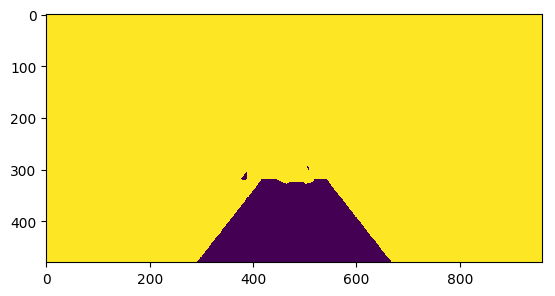

In [5]:
haha = list(np.load('/media/haoming/970EVO/Pharuj/git/DOS/test_station/tf_v.npy'))
(v_e, w_e,control_acc,control_steering_rate) = haha

is_animated = np.load('/media/haoming/970EVO/Pharuj/git/DOS/test_station/tf_animate.npy')

nu = np.load('/media/haoming/970EVO/Pharuj/git/DOS/test_station/tf_nu.npy')
mu = np.load('/media/haoming/970EVO/Pharuj/git/DOS/test_station/tf_mu.npy')

out1, _ = tf.alg1_solver.run((mu,nu,v_e, w_e,control_acc,control_steering_rate, is_animated))
plt.imshow(out1)

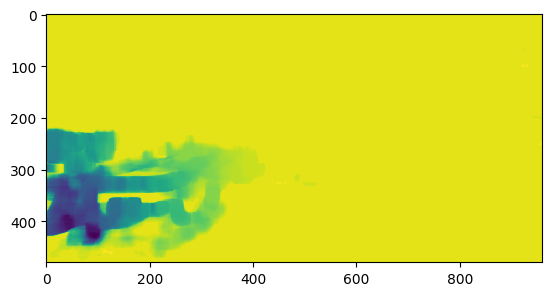

In [6]:
plt.imshow(mu)

-3.191152456879044 0.48564572864031597


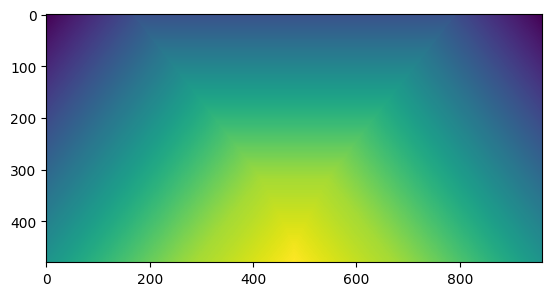

In [7]:
plt.imshow(tf.certification_offset)
print(tf.certification_offset.min(), tf.certification_offset.max())

In [11]:
dm = DM()

focal length:  0.027712812921102045


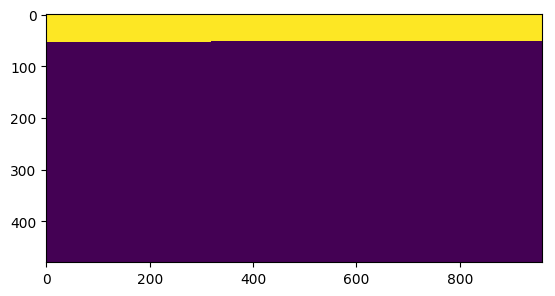

In [12]:
haha = list(np.load('/media/haoming/970EVO/Pharuj/git/DOS/test_station/dm_v.npy'))
(v_e, w_e,control_acc,control_steering_rate) = haha

is_animated = np.load('/media/haoming/970EVO/Pharuj/git/DOS/test_station/dm_animate.npy')

nu = np.load('/media/haoming/970EVO/Pharuj/git/DOS/test_station/dm_nu.npy')
mu = np.load('/media/haoming/970EVO/Pharuj/git/DOS/test_station/dm_mu.npy')

out2, _ = dm.alg1_solver.run((mu,nu,v_e, w_e,control_acc,control_steering_rate, is_animated))
plt.imshow(out2)

In [45]:
dm.certification_offset

array([[-3.19115246, -3.18589796, -3.18064425, ..., -3.17539133,
        -3.18064425, -3.18589796],
       [-3.18703637, -3.18178249, -3.17652939, ..., -3.17127709,
        -3.17652939, -3.18178249],
       [-3.18292076, -3.1776675 , -3.17241502, ..., -3.16716334,
        -3.17241502, -3.1776675 ],
       ...,
       [-1.2955193 , -1.29067871, -1.28583976, ..., -1.28100248,
        -1.28583976, -1.29067871],
       [-1.29172736, -1.28688806, -1.28205041, ..., -1.27721442,
        -1.28205041, -1.28688806],
       [-1.28793644, -1.28309843, -1.27826208, ..., -1.27342739,
        -1.27826208, -1.28309843]])

In [23]:
dm = DM()

focal length:  0.027712812921102045


# MonoDepth


In [5]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.Image as pil
import os
import sys
import torch
from torchvision import transforms

sys.path.append('/media/haoming/970EVO/Yaguang/depth_est/monodepth2')
import networks
from utils import download_model_if_doesnt_exist
# from __future__ import absolute_import, division, print_function




ImportError: cannot import name 'download_model_if_doesnt_exist' from 'utils' (/media/haoming/970EVO/Pharuj/git/transfuser/team_code_transfuser/utils.py)

# Add Depth Noise to the Lidar

In [57]:
import os
import time
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

input_data = np.load("/media/haoming/970EVO/Yaguang/examples/test_data/0030.npy", allow_pickle=True)
lidar_data = input_data[1]
N, _ = lidar_data.shape
b = 1
sigma_i = np.random.uniform(-b, b, N)
exp_sigma_i = np.exp(sigma_i)
print(lidar_data)
lidar_data[:,:3] = lidar_data[:,:3] * exp_sigma_i.reshape(-1, 1)

print(lidar_data)

[[ 3.6069431e+01  0.0000000e+00  6.3600106e+00  8.6372274e-01]
 [ 3.6260956e+01  2.4291015e-01  6.3939281e+00  8.6304826e-01]
 [ 3.6285606e+01  7.2929686e-01  6.3994184e+00  8.6293900e-01]
 ...
 [ 4.3859177e+00 -1.4693359e-01 -2.5336266e+00  9.7993499e-01]
 [ 4.3880272e+00 -5.8789060e-02 -2.5336537e+00  9.7993481e-01]
 [ 4.3883204e+00 -2.9394530e-02 -2.5336628e+00  9.7993481e-01]]
[[ 4.8518909e+01  0.0000000e+00  8.5551882e+00  8.6372274e-01]
 [ 2.2569710e+01  1.5119325e-01  3.9797380e+00  8.6304826e-01]
 [ 2.4675386e+01  4.9594545e-01  4.3518114e+00  8.6293900e-01]
 ...
 [ 5.4590459e+00 -1.8288468e-01 -3.1535437e+00  9.7993499e-01]
 [ 4.2659626e+00 -5.7153687e-02 -2.4631736e+00  9.7993481e-01]
 [ 3.1268234e+00 -2.0944573e-02 -1.8053185e+00  9.7993481e-01]]


In [55]:
lidar_data[:,:3] = lidar_data[:,:3] * exp_sigma_i
print(lidar_data)


ValueError: operands could not be broadcast together with shapes (29735,3) (29735,) 

In [53]:
exp_sigma_i

array([[1.18170411],
       [1.172861  ],
       [1.47876924],
       ...,
       [2.56856379],
       [1.93158361],
       [1.16157247]])

In [38]:
lidar_data

array([[ 3.6069431e+01,  0.0000000e+00,  6.3600106e+00],
       [ 3.6260956e+01,  2.4291015e-01,  6.3939281e+00],
       [ 3.6285606e+01,  7.2929686e-01,  6.3994184e+00],
       ...,
       [ 4.3859177e+00, -1.4693359e-01, -2.5336266e+00],
       [ 4.3880272e+00, -5.8789060e-02, -2.5336537e+00],
       [ 4.3883204e+00, -2.9394530e-02, -2.5336628e+00]], dtype=float32)